In [ ]:
import pandas as pd

In [ ]:
import requests
import pandas as pd
import re
import matplotlib.pyplot as plt
from arch.unitroot import ADF, KPSS

url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=IBM&outputsize=full&apikey=LIDXQ6GY1WVSIDYC'
r = requests.get(url)
data = r.json()
df = pd.DataFrame(data["Time Series (Daily)"])
df = df.T  # Transpose Dataframe for desired results
df = df.rename(columns=lambda x: re.sub('\d+\. *','',x))
df =  df.apply(lambda col:pd.to_numeric(col, errors='coerce'))
df.index = pd.to_datetime(df.index)
df.index.name="date"

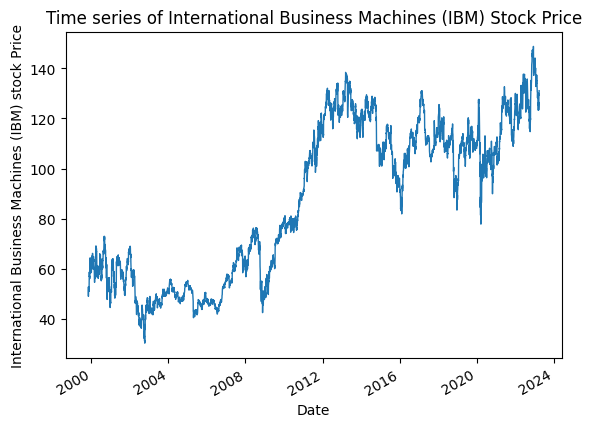

In [ ]:
df["adjusted close"].plot(
    linewidth=1,
    xlabel="Date",
    ylabel="International Business Machines (IBM) stock Price",
    title="Time series of International Business Machines (IBM) Stock Price",
)
plt.show()

We are going to analyze the IBM stock price. The IBM stock price can be a good indicator for modelling non-stationarity and finding an equilibrium because it exhibits several features that are characteristic of non-stationary processes. For example, the stock price of IBM can be influenced by a variety of factors, including macroeconomic indicators, changes in user behavior, technological innovations, and regulatory changes, among others.



In [ ]:
adf_none = ADF(df["adjusted close"], trend="n", method="bic")
print("Augmented Dickey-Fuller Unit Root Test\n", adf_none.regression.summary())
print("\nTest statistics and critical values: \n", adf_none)

Augmented Dickey-Fuller Unit Root Test
                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              1.715
Date:                Mon, 03 Apr 2023   Prob (F-statistic):                       0.190
Time:                        19:12:44   Log-Likelihood:                         -10136.
No. Observations:                5891   AIC:                                  2.027e+04
Df Residuals:                    5890   BIC:                                  2.028e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-

In [ ]:
adf_trend = ADF(df["adjusted close"], trend="ct", method="bic")
print("Augmented Dickey-Fuller Unit Root Test\n", adf_trend.regression.summary())
print("\nTest statistics and critical values: \n", adf_trend)

Augmented Dickey-Fuller Unit Root Test
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.020
Date:                Mon, 03 Apr 2023   Prob (F-statistic):            0.00663
Time:                        19:12:46   Log-Likelihood:                -10132.
No. Observations:                5891   AIC:                         2.027e+04
Df Residuals:                    5888   BIC:                         2.029e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1    

If we perform a Augmented Dickey-Fuller test on the time series of IBM stock data, we get that the Facebook stock price is not stationary, or trend stationary.  For both tests we get a p-value which is above 0.05 which means that we fail to reject the null hypothesis. Hence the series of Facebook stock prices has a unit root.



In [ ]:
print(KPSS(df["adjusted close"], trend="ct", lags=-1))

    KPSS Stationarity Test Results   
Test Statistic                  1.424
P-value                         0.000
Lags                               34
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


We can also perform a KPSS test for stationarity.  In this case, the null hypothesis is that the process is weekly stationary.  We get a low p-value which means that we reject the null hypothesis and conclude that the stock price has a unit root.

The KPSS test works by comparing the sum of the squared deviations from the trend line to the variance of the time series data. If the test statistic is greater than the critical value, the null hypothesis of stationarity is rejected, indicating that the time series is non-stationary. Conversely, if the test statistic is less than the critical value, the null hypothesis of stationarity is not rejected, indicating that the time series is stationary.

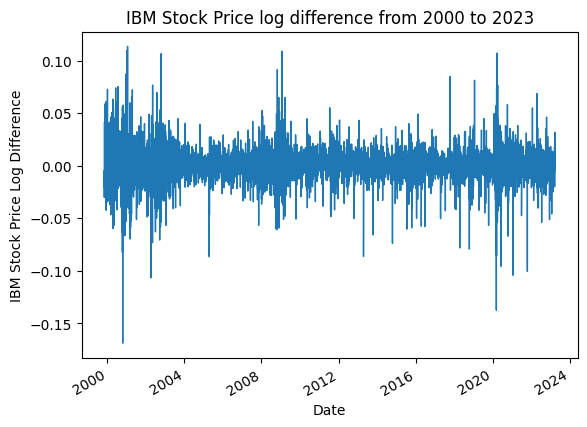

In [ ]:
import numpy as np
libm = np.log(df["adjusted close"][::-1]).diff().dropna()
libm.plot(
    linewidth=1,
    xlabel="Date",
    ylabel="IBM Stock Price Log Difference",
    title="IBM Stock Price log difference from 2000 to 2023",
)
plt.show()

In [ ]:
print("IBM Stock Price Log Difference with no Drift no Trend")
print(ADF(libm, trend="n", method="bic"))

IBM Stock Price Log Difference with no Drift no Trend
   Augmented Dickey-Fuller Results   
Test Statistic                -79.827
P-value                         0.000
Lags                                0
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


To make the series stationary, we instead calculated the log differences in the stock price, which will approximate the daily returns of the IBM stock.  We perform an Augmented Dickey Fuller test and we get that the resulting series is stationary.

For an ADF test, we are working with a model of the form 

$\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \delta_1 \Delta y_{t-1} + \cdots + \delta_{p-1} \Delta y_{t-p+1} + \varepsilon_t$ 

(we can include a trend and drift $\alpha + \beta t$ )

The null hypothesis is that $\gamma = 0$ and the series has a unit root, while the alternative hypothesis is that $\gamma < 0$.

The distribution of values for $\hat \gamma$ is complicated, but we can calculate a test statistic, and if the test statistic is less than the critical value, the null hypothesis of $\gamma = 0$ is rejected and no unit root is present.

In [ ]:
from pmdarima.arima import auto_arima

We split the data into a test and a train set.

In [ ]:
mod_can_auto = auto_arima(
    np.log(df["adjusted close"][::-1]).dropna(),  # stepwise=False,
    start_p=0,
    start_d=0,
    start_q=0,
    max_p=3,
    max_d=3,
    max_q=3,
    trace=True,
    with_intercept=False,
    return_valid_fits=True,
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-31564.951, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-31572.139, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-31572.087, Time=1.75 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-31570.167, Time=0.82 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-31570.172, Time=1.73 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-31568.158, Time=1.62 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-31570.694, Time=0.38 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 7.262 seconds


To model the IBM stock prices we can use an ARIMA Model, which stands for autoregressive integrated moving average model applied to the logarithm of the stock price.

A time series $X_{t}$ follows a ARIMA($p,d,q$) process if $\nabla^{d} X_{t} = (1-B)^{d} X_{t}$ is ARMA($p,q$).

In general, we can write the ARIMA($p,d,q$) as follows:

$$ \nabla^{d} X_{t} = \alpha_{1} \nabla^{d} X_{t-1} + \alpha_{2} \nabla^{d} X_{t-2} + \cdots + \alpha_{p} \nabla^{d} X_{t-p} + \theta_{1} W_{t-1} + \theta_{2} W_{t-2} + \cdots + \theta_{q} W_{t-q} + W_{t} $$

We can also rewrite the model as follows:

$$ \alpha(B) (1-B)^{d} X_{t} = \theta(B) W_{t} $$

In ARIMA($p,d,q$), $p$ is the order of the AR component, $d$ is the order of differencing and $q$ is the order of the MA component.

As we see from the previous analysis, taking first differences should be sufficient.  We use the `auto_arima` function to try all $p$, $d$, and $q$ between $0$ and $3$, and we see that the best model is AR(1) on the first-differences ($p=1$, $d=1$, $q=0$).  This means we do not include a moving average component, and our forecast for the next day's return is based on the current day's return (the difference in the logarithms of the closing prices is approximately the daily return)



## Diagnosis

In [ ]:
mod_can_a = ARIMA(
    np.log(df["adjusted close"][::-1]).dropna(), order=(1, 1, 0), trend="n"
).fit()  # This is the best model in Python implementation
print(mod_can_a.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:         adjusted close   No. Observations:                 5892
Model:                 ARIMA(1, 1, 0)   Log Likelihood               15788.070
Date:                Mon, 03 Apr 2023   AIC                         -31572.139
Time:                        20:09:00   BIC                         -31558.777
Sample:                             0   HQIC                        -31567.495
                               - 5892                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0395      0.008     -4.784      0.000      -0.056      -0.023
sigma2         0.0003   2.23e-06    123.521      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

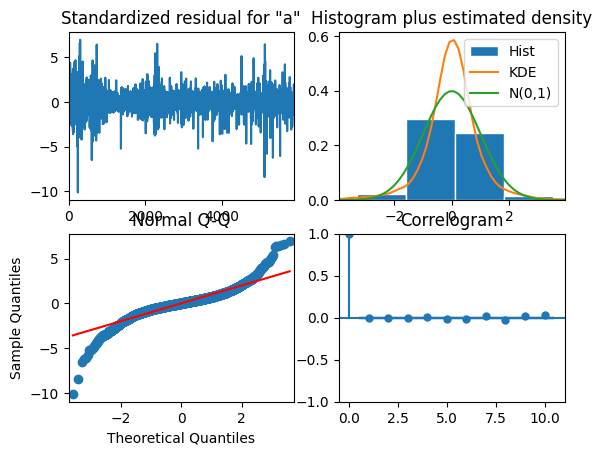

In [ ]:
mod_can_a.plot_diagnostics()
plt.show()

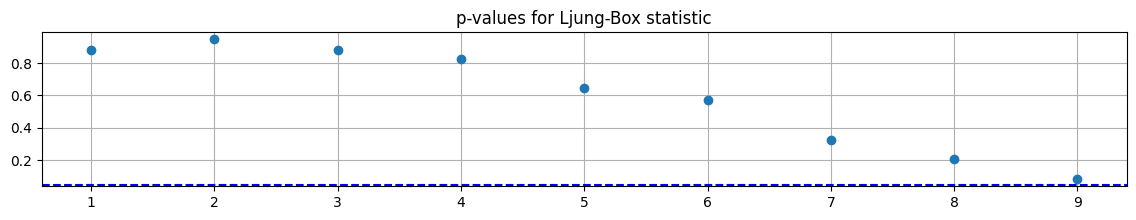

In [ ]:
# Ljung-Box test for no serial correlation of standardized residuals
lb_test = mod_can_a.test_serial_correlation(
    method="ljungbox", df_adjust=True, lags=None
)

# plot Ljung-Box test p-values and 0.05 significance line
plt.figure(figsize=(14, 2))
plt.plot(lb_test[0][1], linestyle="", marker="o")
plt.axhline(y=0.05, color="blue", linestyle="--")
plt.title("p-values for Ljung-Box statistic")
plt.grid()
plt.show()

The model shows a negative coefficient $-0.0395$ for the previous
day's log difference; this indicates that consecutive daily
returns are anticorrelated; a positive return one day makes it
more likely that there will be a negative return the next day.


We can see from the residuals graph that there is are period where the variation is higher than other periods (higher volatility).  In the ACF plot for the residuals, none of the ACFs for lags 1 to 9 are significant at the p=0.05 level, and from the Ljung-Box statistic it looks like the residuals are independent as all the p-values are greater than 0.05. From the QQ plot for the residuals, we can see the residuals are not normally distributed since the plot shows fat tails on both ends.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


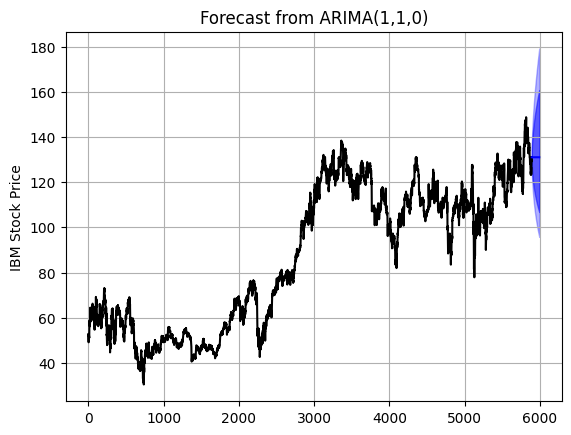

In [ ]:
# Forecast Plot of ARIMA(1,1,0) with 95% Confidence Interval

# Plot IBM data
ffx = df["adjusted close"].copy()[::-1]
ffx.index = [i for i in range(len(ffx))]  # Set numeric index
ffx.plot(ylabel="IBM Stock Price", title="Forecast from ARIMA(1,1,0)", color="k")

# get forecast data for next 100 steps
forecast = mod_can_a.get_forecast(steps=100)
forecast_mean = np.exp(forecast.predicted_mean)  # mean of forecast data
conf_int95 = forecast.conf_int(alpha=0.05)  # 95% confidence interval
conf_int80 = forecast.conf_int(alpha=0.2)  # 80% confidence interval

# plot mean forecast and 95% and 80% confidence intervals
plt.plot(forecast_mean, c="b")
plt.fill_between(
    conf_int95.index,
    np.exp(conf_int95["lower adjusted close"]),
    np.exp(conf_int95["upper adjusted close"]),
    color="b",
    alpha=0.3,
)
plt.fill_between(
    conf_int80.index,
    np.exp(conf_int80["lower adjusted close"]),
    np.exp(conf_int80["upper adjusted close"]),
    color="b",
    alpha=0.5,
)
plt.grid()
plt.show()

By using an ARIMA model, we have forecast that there is a 79 percent chance that the IBM stock will move for the next 100 days between 110 and 160, and a 95% chance that it will move between 95 and 180.

## Damage

Some problems with the model are that we can see fat tails on the residuals, and that there are periods where the residuals are higher and lower, suggesting that there is a regime change in the volatility.  Instead of using an AR(1) model, we can try using a GARCH model which will take into account the heteroskedacticity.  

The daily returns on IBM stock appear to be skewed and have fat tails (leptokurtic distribution).  This suggests that we should use a model based on Student-t or a skewed version of it rather than the normal distribution.
 

Text(0.5, 0, 'Return')

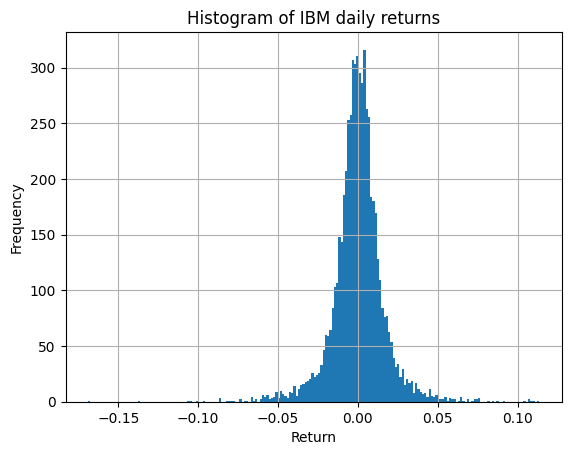

In [ ]:
libm.hist(bins=200)
plt.title("Histogram of IBM daily returns")
plt.ylabel("Frequency")
plt.xlabel("Return")

## Directions

If we want to keep the same model, but change the data to make it more accurate, we can try shortening the time horizon; if we only look at relatively recent data we have a better estimate of the current levels of volatility without having to switch to a GARCH model.

We can also try looking at returns on various time scales i.e. daily returns, weekly or monthly returns.

Outliers can have an impact on the parameters of an ARIMA model. Removing outliers can improve the accuracy of the model and allow us to come up with more accurate estimates for the parameters.

## Deployment

We can use the model to make forecasts of IBM daily stock returns. This can help you make informed decisions about investing in IBM stock or managing your portfolio.

To deploy the ARIMA model in a financial context, we can present the model in a dashboard or application to visualize the results and make them accessible to stakeholders. For example, you may create a dashboard that displays the forecasted IBM stock returns alongside actual returns, as well as other relevant financial data such as market trends or news articles. This can help stakeholders understand the risks and potential rewards of investing in IBM stock and make informed decisions about their financial strategies.

The confidence intervals can help us make financial decisions because we can look at the range and if it is too volatile, we can limit exposure to IBM by allocating more of your portfolio to less volatile assets such as bonds or cash.

An ARIMA model might also indicate directionality due to the moving average component; if it indicates that IBM stock returns are likely to increase you may consider buying shares in IBM to take advantage of potential gains. Conversely, if the forecast indicates that IBM stock returns are likely to decrease, you may consider selling shares in IBM to avoid potential losses. For the choice of parameters we found we see that $q = 0$ was best, so our forecasts will be always centered around the current stock price. 
